<a href="https://colab.research.google.com/github/snehotosh/Deep-Learning/blob/master/7_Transfer_Learning_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
#!pip install -q keras

# Cats and Dogs transfer learning

## Data preparation

Download and unzip the cats and dogs dataset.

In [0]:
%%capture
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip
!mv PetImages train
!find train/Cat -size  0 -print0 |xargs -0 rm --
!find train/Dog -size  0 -print0 |xargs -0 rm --

In [4]:
!ls


 kagglecatsanddogs_3367a.zip  'readme[1].txt'   train
'MSR-LA - 3467.docx'	       sample_data


Split some data for testing and validation.

In [0]:
from glob import glob
from sklearn.model_selection import train_test_split

cats = glob('train/Cat/*.jpg')
dogs = glob('train/Dog/*.jpg')

cats_train, cats_test = train_test_split(cats, test_size=0.30)
dogs_train, dogs_test = train_test_split(dogs, test_size=0.30)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

!mkdir test

!mkdir test/Cat
files = ' '.join(cats_test)
!mv -t test/Cat $files

!mkdir test/Dog
files = ' '.join(dogs_test)
!mv -t test/Dog $files

In [6]:
print(cats)

['train/Cat/2977.jpg', 'train/Cat/11291.jpg', 'train/Cat/11240.jpg', 'train/Cat/10463.jpg', 'train/Cat/3705.jpg', 'train/Cat/6619.jpg', 'train/Cat/7064.jpg', 'train/Cat/3876.jpg', 'train/Cat/9137.jpg', 'train/Cat/578.jpg', 'train/Cat/7126.jpg', 'train/Cat/6673.jpg', 'train/Cat/9666.jpg', 'train/Cat/2644.jpg', 'train/Cat/1918.jpg', 'train/Cat/8343.jpg', 'train/Cat/8422.jpg', 'train/Cat/4026.jpg', 'train/Cat/3915.jpg', 'train/Cat/2206.jpg', 'train/Cat/12455.jpg', 'train/Cat/9521.jpg', 'train/Cat/2512.jpg', 'train/Cat/6410.jpg', 'train/Cat/2920.jpg', 'train/Cat/8271.jpg', 'train/Cat/900.jpg', 'train/Cat/7693.jpg', 'train/Cat/6959.jpg', 'train/Cat/2479.jpg', 'train/Cat/9326.jpg', 'train/Cat/5099.jpg', 'train/Cat/4877.jpg', 'train/Cat/751.jpg', 'train/Cat/7930.jpg', 'train/Cat/1836.jpg', 'train/Cat/9660.jpg', 'train/Cat/12323.jpg', 'train/Cat/11827.jpg', 'train/Cat/11148.jpg', 'train/Cat/2671.jpg', 'train/Cat/9232.jpg', 'train/Cat/2254.jpg', 'train/Cat/4635.jpg', 'train/Cat/6132.jpg', 'trai

Plot some random images from the dataset.

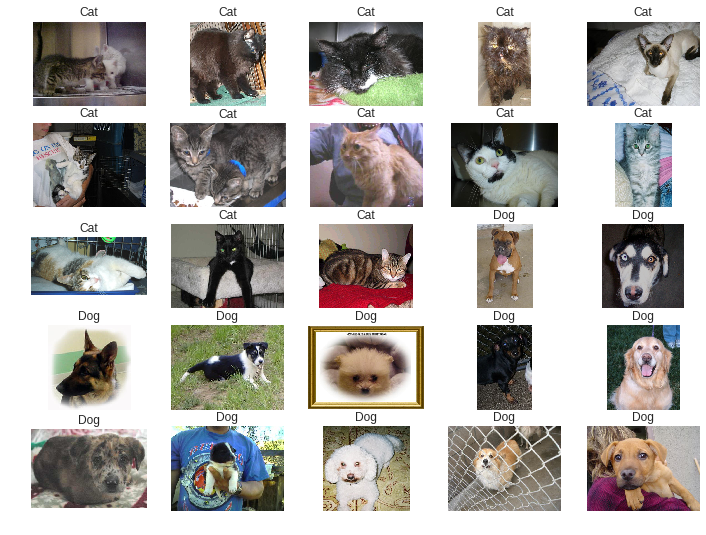

In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

cats = np.random.choice(cats_train, 13)
dogs = np.random.choice(dogs_train, 12)
data = np.concatenate((cats, dogs))
labels = 13 * ['Cat'] + 12 *['Dog']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

## Model customization

In [8]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Data augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 17498 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


Plot some images result of data augmentation.

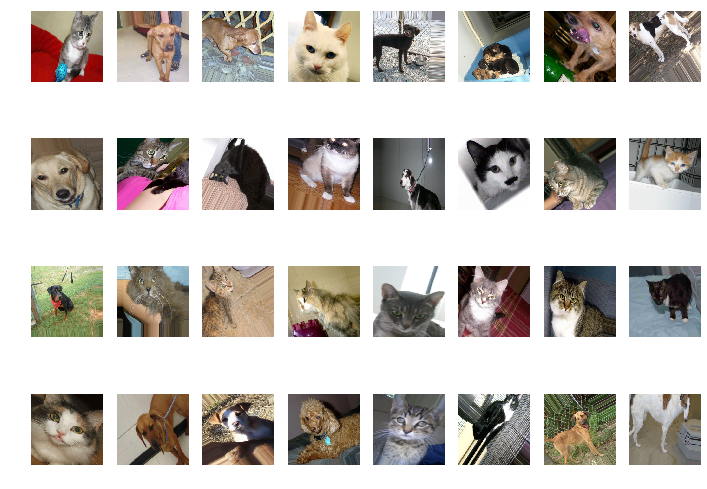

In [10]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Transfer learning

In [11]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'filename.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 70/320 [=====>........................] - ETA: 4:04 - loss: 0.3812 - acc: 0.8375

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


 75/320 [======>.......................] - ETA: 3:57 - loss: 0.3704 - acc: 0.8417

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting 

132/320 [===========>..................] - ETA: 2:52 - loss: 0.3086 - acc: 0.8684

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


228/320 [====================>.........] - ETA: 1:22 - loss: 0.2564 - acc: 0.8913

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expectin

320/320 [==============================] - 336s 1s/step - loss: 0.2294 - acc: 0.9037 - val_loss: 0.1132 - val_acc: 0.9595
Epoch 2/5
 79/320 [======>.......................] - ETA: 3:14 - loss: 0.1669 - acc: 0.9308

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

319/320 [============================>.] - ETA: 0s - loss: 0.1541 - acc: 0.9381

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expectin

320/320 [==============================] - 325s 1s/step - loss: 0.1542 - acc: 0.9380 - val_loss: 0.1941 - val_acc: 0.9346
Epoch 3/5
 10/320 [..............................] - ETA: 1:37 - loss: 0.1798 - acc: 0.9219

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 5357. Skipping tag 513
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expectin

320/320 [==============================] - 324s 1s/step - loss: 0.1412 - acc: 0.9442 - val_loss: 0.0796 - val_acc: 0.9692
Epoch 4/5
320/320 [==============================] - 324s 1s/step - loss: 0.1407 - acc: 0.9474 - val_loss: 0.0872 - val_acc: 0.9729
Epoch 5/5
320/320 [==============================] - 325s 1s/step - loss: 0.1439 - acc: 0.9458 - val_loss: 0.2135 - val_acc: 0.9321


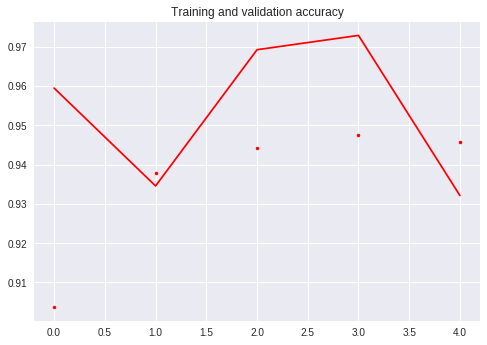

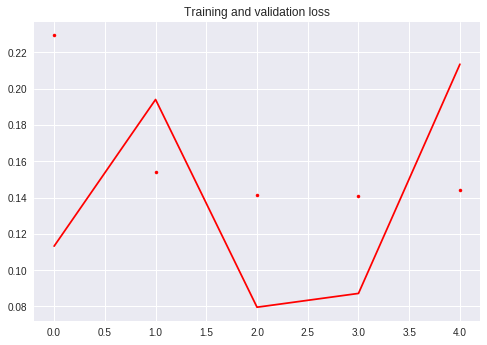

In [16]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

## Prediction of the custom model

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("cat", "dog")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [0]:
model = load_model(MODEL_FILE)

In [22]:
!ls test/Dog

10001.jpg  11630.jpg  1898.jpg	3556.jpg  5170.jpg  6809.jpg  8396.jpg
10003.jpg  11631.jpg  1899.jpg	3558.jpg  5173.jpg  6813.jpg  8398.jpg
10005.jpg  11635.jpg  18.jpg	3564.jpg  5181.jpg  6815.jpg  8403.jpg
10009.jpg  11638.jpg  1908.jpg	3565.jpg  5183.jpg  6822.jpg  8404.jpg
10014.jpg  11640.jpg  1911.jpg	3568.jpg  5190.jpg  6824.jpg  8408.jpg
10015.jpg  11641.jpg  1914.jpg	3570.jpg  5191.jpg  6828.jpg  8412.jpg
10021.jpg  11647.jpg  1915.jpg	3571.jpg  5198.jpg  682.jpg   8417.jpg
10022.jpg  11655.jpg  1919.jpg	3573.jpg  519.jpg   6830.jpg  8418.jpg
10024.jpg  11657.jpg  1923.jpg	357.jpg   5202.jpg  6831.jpg  8419.jpg
10029.jpg  11658.jpg  1926.jpg	3586.jpg  5204.jpg  6842.jpg  8421.jpg
1002.jpg   11662.jpg  1928.jpg	3588.jpg  5207.jpg  6846.jpg  8422.jpg
10030.jpg  11663.jpg  1935.jpg	358.jpg   5210.jpg  6848.jpg  8424.jpg
10032.jpg  11666.jpg  193.jpg	3590.jpg  5214.jpg  6849.jpg  8426.jpg
10035.jpg  11669.jpg  1942.jpg	3595.jpg  5220.jpg  6850.jpg  842.jpg
10036.jpg  1166.jpg   19

array([0.02701314, 0.9729868 ], dtype=float32)

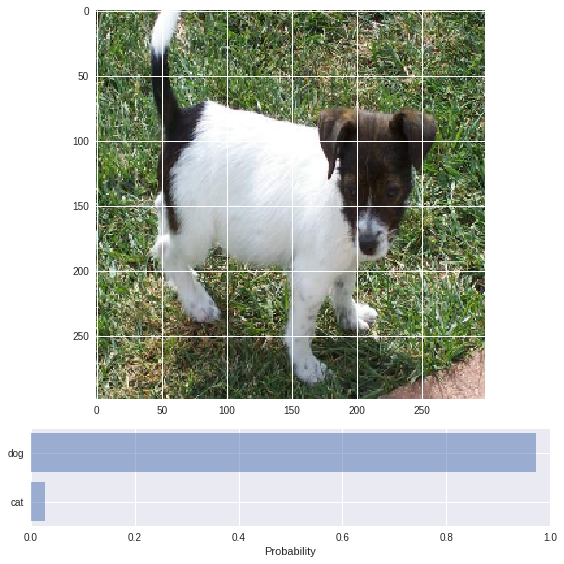

In [23]:
img = image.load_img('test/Dog/8110.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds